In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn as nn
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizerFast
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
import evaluate
from transformers import AutoTokenizer
from transformers import (
    DebertaV2TokenizerFast, 
    DebertaV2ForSequenceClassification, 
    TrainingArguments, 
    Trainer, 
    EarlyStoppingCallback
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### Loading and preprocessing the data

In [3]:
train = pd.read_csv(r"D:\Data Science Projects\AI Emotion Analysis\data\train_upsampled.csv")
train = train.drop_duplicates(subset=['text'])
val = pd.read_csv(r"D:\Data Science Projects\AI Emotion Analysis\data\val.csv")
test = pd.read_csv(r"D:\Data Science Projects\AI Emotion Analysis\data\test.csv")

### Preprocessing the data

In [4]:
# emotion label mapping
emotion_labels = { 
    "Anger": 0, "Fear": 1, "Happy": 2, "Sadness": 3, 
    "Neutral": 4, "Surprise": 5, "Confusion": 6, "Disgust": 7 
}

# mapping emotion labels to integers
train["label"] = train["emotion"].map(emotion_labels)
val["label"] = val["emotion"].map(emotion_labels)
test["label"] = test["emotion"].map(emotion_labels)

# Dropping any NA values
train = train.dropna(subset=["text", "label"]).reset_index(drop=True)
val = val.dropna(subset=["text", "label"]).reset_index(drop=True)
test = test.dropna(subset=["text", "label"]).reset_index(drop=True)

# Convert text column to strings
train["text"] = train["text"].astype(str)
val["text"] = val["text"].astype(str)
test["text"] = test["text"].astype(str)

# Extract lists of texts and labels
train_texts = train["text"].tolist()
train_labels = train["label"].tolist()

val_texts = val["text"].tolist()
val_labels = val["label"].tolist()

test_texts = test["text"].tolist()
test_labels = test["label"].tolist()

print(f"Train: {len(train_texts)} samples")
print(f"Validation: {len(val_texts)} samples")
print(f"Test: {len(test_texts)} samples")

Train: 429858 samples
Validation: 45785 samples
Test: 50872 samples


In [5]:
from collections import Counter

print("Class distribution after oversampling:")
print(Counter(train_labels))

Class distribution after oversampling:
Counter({2: 128849, 3: 101300, 4: 82963, 0: 49822, 1: 41952, 5: 11284, 7: 6927, 6: 6761})


### DistilBERT Model

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)

train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": train_labels})
val_dataset = Dataset.from_dict({"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"], "labels": val_labels})
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"], "labels": test_labels})

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['label']),
    y=train['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")

In [ ]:
class WeightedDistilBERT(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super(WeightedDistilBERT, self).__init__()
        self.num_labels = num_labels
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        # Get outputs from the base model
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Extract logits
        logits = outputs.logits

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))

        # Return the model output in the expected format
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilbert-base-uncased"
num_labels = len(np.unique(train['label']))


model = WeightedDistilBERT(model_name, num_labels=num_labels, class_weights=class_weights).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",  
    evaluation_strategy="epoch",  
    save_strategy="epoch",  
    logging_strategy="epoch",  
    logging_dir="./logs",  
    logging_steps=10,  
    learning_rate=1e-5,  
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,  
    num_train_epochs=4,  
    weight_decay=0.05,  
    max_grad_norm=1.0,  
    load_best_model_at_end=True,  
    disable_tqdm=False,  
    report_to="none",  
    lr_scheduler_type="linear",  
    warmup_steps=500,  
    fp16=True,  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,    
    tokenizer=tokenizer,     
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

c:\Users\aliir\anaconda3\envs\py310\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\aliir\AppData\Local\Temp\ipykernel_42392\1289792415.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [60]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.447000,0.263121
2,0.268100,0.259329
3,0.209800,0.243414
4,0.175000,0.239064


TrainOutput(global_step=53736, training_loss=0.274960734685546, metrics={'train_runtime': 5161.2051, 'train_samples_per_second': 333.145, 'train_steps_per_second': 10.412, 'total_flos': 0.0, 'train_loss': 0.274960734685546, 'epoch': 4.0})

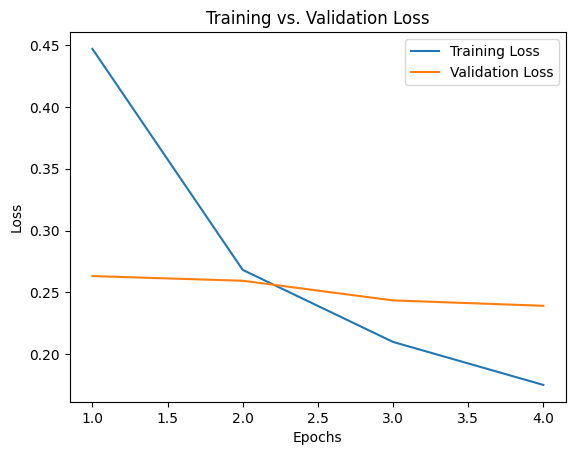

In [ ]:
train_losses = trainer.state.log_history
val_losses = [log['eval_loss'] for log in train_losses if 'eval_loss' in log]
epochs = range(1, len(val_losses) + 1)

plt.plot(epochs, [log['loss'] for log in train_losses if 'loss' in log], label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [ ]:
# Load test dataset predictions
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
labels = predictions.label_ids

# Loading metrics using the evaluate library
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Compute evaluation metrics
accuracy = accuracy_metric.compute(predictions=preds, references=labels)
precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")
recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")
f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")

print(f"Accuracy: {accuracy['accuracy']:.4f}")
print(f"Precision: {precision['precision']:.4f}")
print(f"Recall: {recall['recall']:.4f}")
print(f"F1 Score: {f1['f1']:.4f}")


Accuracy: 0.9329
Precision: 0.9377
Recall: 0.9329
F1 Score: 0.9337


In [63]:
from sklearn.metrics import classification_report

target_names = {v: k for k, v in emotion_labels.items()} 
target_names = [target_names[label] for label in sorted(target_names.keys())]

report = classification_report(labels, preds, target_names=target_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       Anger       0.96      0.90      0.93      6378
        Fear       0.90      0.98      0.94      4752
       Happy       0.98      0.90      0.94     16317
     Sadness       0.98      0.97      0.97     12414
     Neutral       0.83      0.95      0.89      9335
    Surprise       0.84      0.83      0.84      1421
   Confusion       0.69      0.75      0.72       154
     Disgust       0.57      0.80      0.66       101

    accuracy                           0.93     50872
   macro avg       0.84      0.89      0.86     50872
weighted avg       0.94      0.93      0.93     50872



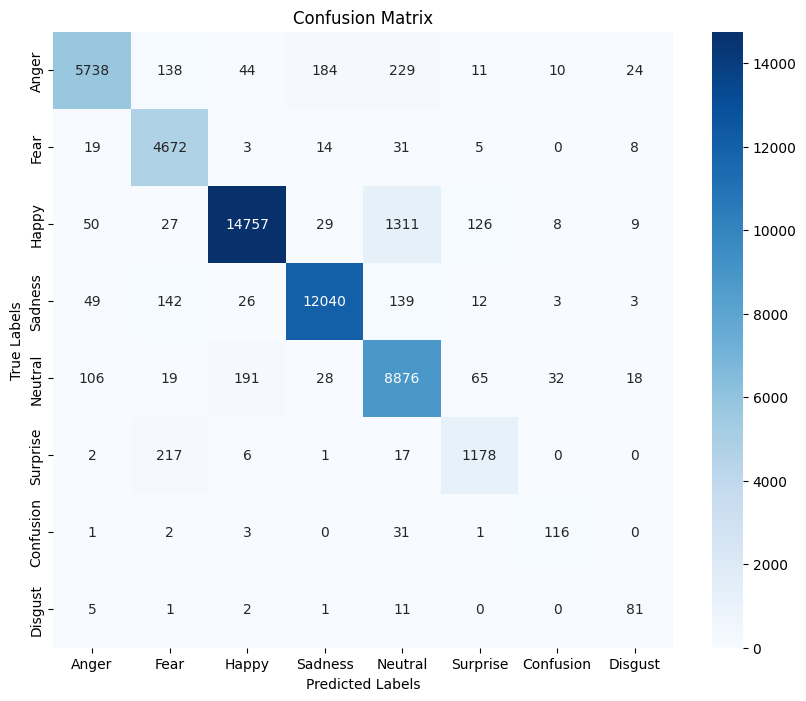

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(labels, preds)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch

def save_custom_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_weights': model.loss_fn.weight 
    }, path)

save_custom_model(model, "./best_model/custom_model_weighted_distilBERT.pth")
tokenizer.save_pretrained("./best_model")

In [68]:
tokenizer.save_pretrained("./best_model")

('./best_model\\tokenizer_config.json',
 './best_model\\special_tokens_map.json',
 './best_model\\vocab.txt',
 './best_model\\added_tokens.json',
 './best_model\\tokenizer.json')

In [ ]:
def load_custom_model(model_class, model_path, model_name, num_labels):
    checkpoint = torch.load(model_path)  
    model = model_class(model_name, num_labels, checkpoint['class_weights'])  
    model.load_state_dict(checkpoint['model_state_dict'])  
    return model

def predict(text, model, tokenizer, device, max_length=512):
    encoding = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model.eval()
    model.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = load_custom_model(WeightedDistilBERT, "./best_model_DISTILBERT/custom_model_weighted_distilBERT.pth", model_name="distilbert-base-uncased", num_labels=8)
tokenizer = AutoTokenizer.from_pretrained("./best_model_DISTILBERT")

model = model.to(device)

text = "The smell of that food was so awful, I could barely stand to be in the room."

predicted_class = predict(text, model, tokenizer, device, max_length=512)
print(f"Predicted class: {predicted_class}")

reverse_emotion_labels = {v: k for k, v in emotion_labels.items()}

predicted_emotion = reverse_emotion_labels[predicted_class]
print(f"Predicted emotion: {predicted_emotion}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 7
Predicted emotion: Disgust


In [ ]:
text = "i was beginning to feel quite disheartened"

predicted_class = predict(text, model, tokenizer, device, max_length=512)
print(f"Predicted class: {predicted_class}")

reverse_emotion_labels = {v: k for k, v in emotion_labels.items()}

predicted_emotion = reverse_emotion_labels[predicted_class]
print(f"Predicted emotion: {predicted_emotion}")

Predicted class: 3
Predicted emotion: Sadness


In [102]:
df_data = pd.read_csv("D:\Data Science Projects\AI Emotion Analysis\data\emotion_dataset_to_check_model.csv")

In [103]:
df_data

,Text,Emotion
0,"I've been feeling really good lately, like eve...",Happy
1,"I finally got the job I always wanted, and I c...",Happy
2,Spending time with my family this weekend was ...,Happy
3,"I try to stay positive, but some days it just ...",Sadness
4,"Ever since they left, it feels like a part of ...",Sadness
5,I keep thinking about all the mistakes I’ve ma...,Sadness
6,I can't believe they betrayed my trust like that!,Anger
7,"Every time I try to explain myself, no one lis...",Anger
8,"I did everything right, and yet I’m the one wh...",Anger
9,I keep having this sinking feeling that someth...,Fear


In [ ]:
reverse_emotion_labels = {v: k for k, v in emotion_labels.items()}

predictions = []

for text in df_data["Text"]:
    predicted_class = predict(text, model, tokenizer, device, max_length=512)
    predicted_emotion = reverse_emotion_labels[predicted_class]
    predictions.append(predicted_emotion)

df_data["predicted_emotion"] = predictions

df_data["correct"] = df_data["Emotion"] == df_data["predicted_emotion"]

accuracy = df_data["correct"].mean()
print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 37.50%


In [107]:
df_data

,Text,Emotion,predicted_emotion,correct
0,"I've been feeling really good lately, like eve...",Happy,Neutral,False
1,"I finally got the job I always wanted, and I c...",Happy,Happy,True
2,Spending time with my family this weekend was ...,Happy,Happy,True
3,"I try to stay positive, but some days it just ...",Sadness,Neutral,False
4,"Ever since they left, it feels like a part of ...",Sadness,Neutral,False
5,I keep thinking about all the mistakes I’ve ma...,Sadness,Neutral,False
6,I can't believe they betrayed my trust like that!,Anger,Surprise,False
7,"Every time I try to explain myself, no one lis...",Anger,Anger,True
8,"I did everything right, and yet I’m the one wh...",Anger,Sadness,False
9,I keep having this sinking feeling that someth...,Fear,Sadness,False


### BERT Based Uncased

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['label']),
    y=train['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")

In [ ]:
class WeightedBERT(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super(WeightedBERT, self).__init__()
        self.num_labels = num_labels
        self.model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(loss=loss, logits=logits)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "bert-base-uncased"
num_labels = len(emotion_labels)

model = WeightedBERT(model_name, num_labels=num_labels, class_weights=class_weights).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    load_best_model_at_end=True,
    disable_tqdm=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aliir\anaconda3\envs\py310\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\aliir\AppData\Local\Temp\ipykernel_27636\216016883.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.390200,0.251277
2,0.253200,0.248924
3,0.173900,0.240661
4,0.122300,0.257992
5,0.086100,0.282761


TrainOutput(global_step=134335, training_loss=0.205128972258021, metrics={'train_runtime': 22689.3976, 'train_samples_per_second': 113.672, 'train_steps_per_second': 7.105, 'total_flos': 0.0, 'train_loss': 0.205128972258021, 'epoch': 5.0})

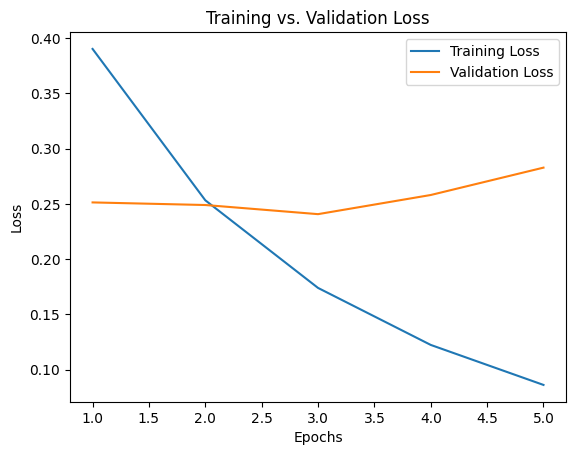

In [14]:
import matplotlib.pyplot as plt

train_losses = trainer.state.log_history
val_losses = [log['eval_loss'] for log in train_losses if 'eval_loss' in log]
epochs = range(1, len(val_losses) + 1)

plt.plot(epochs, [log['loss'] for log in train_losses if 'loss' in log], label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [ ]:
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
labels = predictions.label_ids

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# metrics
accuracy = accuracy_metric.compute(predictions=preds, references=labels)
precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")
recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")
f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")

print(f"Accuracy: {accuracy['accuracy']:.4f}")
print(f"Precision: {precision['precision']:.4f}")
print(f"Recall: {recall['recall']:.4f}")
print(f"F1 Score: {f1['f1']:.4f}")

Accuracy: 0.9471
Precision: 0.9501
Recall: 0.9471
F1 Score: 0.9474


In [16]:
# Classification report
from sklearn.metrics import classification_report

target_names = {v: k for k, v in emotion_labels.items()}
target_names = [target_names[label] for label in sorted(target_names.keys())]

report = classification_report(labels, preds, target_names=target_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       Anger       0.98      0.92      0.95      6378
        Fear       0.90      0.99      0.94      4752
       Happy       0.98      0.93      0.95     16317
     Sadness       0.98      0.98      0.98     12414
     Neutral       0.87      0.97      0.91      9335
    Surprise       0.88      0.82      0.85      1421
   Confusion       0.86      0.71      0.78       154
     Disgust       0.72      0.79      0.75       101

    accuracy                           0.95     50872
   macro avg       0.90      0.89      0.89     50872
weighted avg       0.95      0.95      0.95     50872



In [ ]:
import torch

def save_custom_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_weights': model.loss_fn.weight
    }, path)


save_custom_model(model, "./best_model_BERT/custom_model_weighted_BERT.pth")
tokenizer.save_pretrained("./best_model_BERT")

('./best_model_BERT\\tokenizer_config.json',
 './best_model_BERT\\special_tokens_map.json',
 './best_model_BERT\\vocab.txt',
 './best_model_BERT\\added_tokens.json',
 './best_model_BERT\\tokenizer.json')

### DeBERTa 

##### DeBERTa Model with MAX_LENGTH= 128

In [ ]:
tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v3-small")

def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)

# Dataset
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['label']),
    y=train['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")

c:\Users\aliir\anaconda3\envs\py310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
class WeightedDeBERTa(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super(WeightedDeBERTa, self).__init__()
        self.num_labels = num_labels
        self.model = DebertaV2ForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(p=0.2)  # Add extra dropout
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.dropout(outputs.logits)  # Apply dropout before classification
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
        return SequenceClassifierOutput(loss=loss, logits=logits)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "microsoft/deberta-v3-small"
num_labels = len(np.unique(train['label']))

model = WeightedDeBERTa(model_name, num_labels=num_labels, class_weights=class_weights).to(device)

training_args = TrainingArguments(
    output_dir="./deberta_results",          
    evaluation_strategy="epoch",             
    save_strategy="epoch",                   
    logging_strategy="epoch",                
    logging_dir="./deberta_logs",            
    logging_steps=10,                        
    learning_rate=1e-5,                      
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=16,           
    num_train_epochs=4,                      
    weight_decay=0.05,                       
    max_grad_norm=1.0,                      
    load_best_model_at_end=True,             
    disable_tqdm=False,                     
    report_to="none",                        
    lr_scheduler_type="linear",              
    warmup_steps=500,                        
    fp16=True,                               
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\aliir\AppData\Local\Temp\ipykernel_16464\2244653936.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.623200,0.325151
2,0.476300,0.314058
3,0.424600,0.295252
4,0.389600,0.284883


TrainOutput(global_step=107468, training_loss=0.4784395940099611, metrics={'train_runtime': 12814.3486, 'train_samples_per_second': 134.18, 'train_steps_per_second': 8.387, 'total_flos': 0.0, 'train_loss': 0.4784395940099611, 'epoch': 4.0})

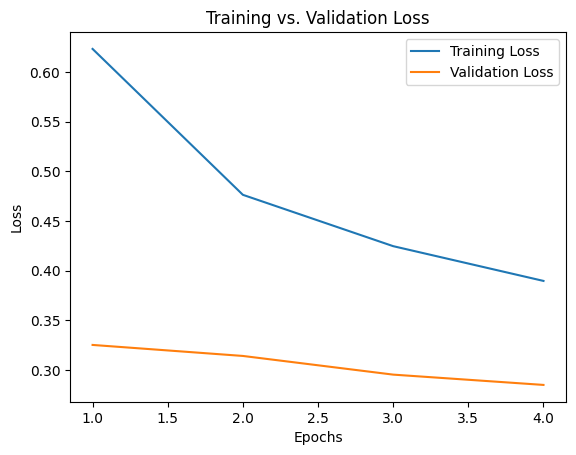

In [12]:
import matplotlib.pyplot as plt

train_losses = trainer.state.log_history
val_losses = [log['eval_loss'] for log in train_losses if 'eval_loss' in log]
epochs = range(1, len(val_losses) + 1)

plt.plot(epochs, [log['loss'] for log in train_losses if 'loss' in log], label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [ ]:
# Evaluate model on test data
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
labels = predictions.label_ids

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Compute metrics
accuracy = accuracy_metric.compute(predictions=preds, references=labels)
precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")
recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")
f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")

# Print metrics
print(f"Accuracy: {accuracy['accuracy']:.4f}")
print(f"Precision: {precision['precision']:.4f}")
print(f"Recall: {recall['recall']:.4f}")
print(f"F1 Score: {f1['f1']:.4f}")

Accuracy: 0.9373
Precision: 0.9401
Recall: 0.9373
F1 Score: 0.9378


In [14]:
# Classification report
from sklearn.metrics import classification_report

target_names = {v: k for k, v in emotion_labels.items()}
target_names = [target_names[label] for label in sorted(target_names.keys())]

report = classification_report(labels, preds, target_names=target_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       Anger       0.96      0.90      0.93      6378
        Fear       0.90      0.98      0.94      4752
       Happy       0.98      0.92      0.95     16317
     Sadness       0.98      0.97      0.97     12414
     Neutral       0.86      0.94      0.90      9335
    Surprise       0.85      0.82      0.84      1421
   Confusion       0.67      0.67      0.67       154
     Disgust       0.61      0.70      0.65       101

    accuracy                           0.94     50872
   macro avg       0.85      0.87      0.86     50872
weighted avg       0.94      0.94      0.94     50872



In [ ]:
import torch

torch.save({
    'model_state_dict': model.state_dict(), 
    'class_weights': model.loss_fn.weight
}, './deberta_best_model/custom_model.pth')

tokenizer.save_pretrained("./deberta_best_model")
model.model.config.save_pretrained("./deberta_best_model")

print("✅ Model saved successfully!")

✅ Model saved successfully!


##### DeBERTa Model with MAX_LENGTH= 256

In [ ]:
tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v3-small")

def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=256)

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)

# Dataset
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['label']),
    y=train['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")

c:\Users\aliir\anaconda3\envs\py310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
class WeightedDeBERTa(nn.Module):
    def __init__(self, model_name, num_labels, class_weights):
        super(WeightedDeBERTa, self).__init__()
        self.num_labels = num_labels
        self.model = DebertaV2ForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(p=0.3)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.dropout(outputs.logits)  # Apply dropout before classification
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
        return SequenceClassifierOutput(loss=loss, logits=logits)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "microsoft/deberta-v3-small"
num_labels = len(np.unique(train['label']))

model = WeightedDeBERTa(model_name, num_labels=num_labels, class_weights=class_weights).to(device)

training_args = TrainingArguments(
    output_dir="./deberta_results",          
    evaluation_strategy="epoch",             
    save_strategy="epoch",                  
    logging_strategy="epoch",                
    logging_dir="./deberta_logs",            
    logging_steps=10,                        
    learning_rate=1e-5,                      
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=16,          
    num_train_epochs=4,                      
    weight_decay=0.05,                       
    max_grad_norm=1.0,                       
    load_best_model_at_end=True,             
    disable_tqdm=False,                      
    report_to="none",                        
    lr_scheduler_type="linear",              
    warmup_steps=500,                        
    fp16=True,                               
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aliir\anaconda3\envs\py310\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\aliir\AppData\Local\Temp\ipykernel_22988\601379590.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.762500,0.308888
2,0.624900,0.307518
3,0.579600,0.291787
4,0.547100,0.281620


TrainOutput(global_step=107468, training_loss=0.628535100274035, metrics={'train_runtime': 20460.6476, 'train_samples_per_second': 84.036, 'train_steps_per_second': 5.252, 'total_flos': 0.0, 'train_loss': 0.628535100274035, 'epoch': 4.0})

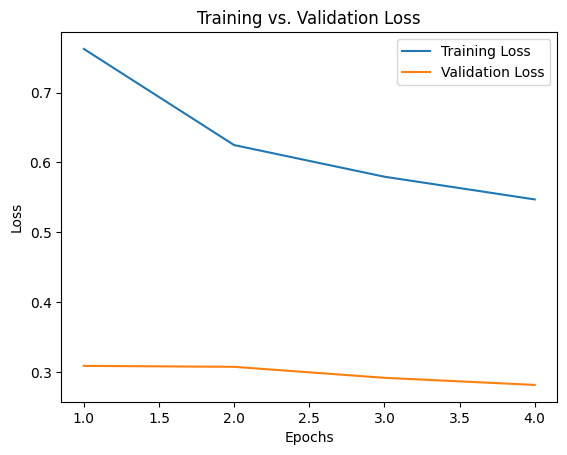

In [9]:
import matplotlib.pyplot as plt

train_losses = trainer.state.log_history
val_losses = [log['eval_loss'] for log in train_losses if 'eval_loss' in log]
epochs = range(1, len(val_losses) + 1)

plt.plot(epochs, [log['loss'] for log in train_losses if 'loss' in log], label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [ ]:
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
labels = predictions.label_ids

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

accuracy = accuracy_metric.compute(predictions=preds, references=labels)
precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")
recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")
f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")

# Metrics
print(f"Accuracy: {accuracy['accuracy']:.4f}")
print(f"Precision: {precision['precision']:.4f}")
print(f"Recall: {recall['recall']:.4f}")
print(f"F1 Score: {f1['f1']:.4f}")

Accuracy: 0.9365
Precision: 0.9394
Recall: 0.9365
F1 Score: 0.9369


In [ ]:
from sklearn.metrics import classification_report

target_names = {v: k for k, v in emotion_labels.items()}
target_names = [target_names[label] for label in sorted(target_names.keys())]

report = classification_report(labels, preds, target_names=target_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       Anger       0.97      0.90      0.93      6378
        Fear       0.89      0.98      0.94      4752
       Happy       0.97      0.92      0.95     16317
     Sadness       0.98      0.97      0.97     12414
     Neutral       0.86      0.94      0.90      9335
    Surprise       0.85      0.82      0.84      1421
   Confusion       0.68      0.62      0.65       154
     Disgust       0.58      0.70      0.63       101

    accuracy                           0.94     50872
   macro avg       0.85      0.86      0.85     50872
weighted avg       0.94      0.94      0.94     50872



In [ ]:
torch.save({
    'model_state_dict': model.state_dict(), 
    'class_weights': model.loss_fn.weight
}, './deberta_best_model_2/custom_model.pth')

tokenizer.save_pretrained("./deberta_best_model_2")
model.model.config.save_pretrained("./deberta_best_model_2")

print("✅ Model saved successfully!")

✅ Model saved successfully!
